# Project: Advanced Lane Finding

In this project, camera calibration and pipeline for lane finding is described.

## Camera Calibration

Due to the lenses used in the camera, we can't get a perfect picture from a camera. Due to radial and tangential distortion, we will get a distorted image. To counter this effect we have to undistort the image using mathematical transformations. In this notebook, we will take images from the camera and undistort them.

Following is the distorted image taken by an action camera which we are going to use for camera calibration.

![](./camera_cal_udacity/calibration1.jpg)

### Import Python Modules:

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('Importing python modules completed.')

Importing python modules completed.


### Corners initialization:

Enter the number of inside corners(i.e. corners at which there is intersection of 2 black and 2 white blocks) in the cell below.

In [2]:
# prepare object points
nx = 7   # TODO: enter the number of inside corners in x
ny = 5   # TODO: enter the number of inside corners in y

# Set file name for calibration images
fname = './camera_cal_udac/2.JPG'

### Import Chessboard Image:

Matplotlib and opencv library displays images in different colorspace so image has to be converted from BGR to RGB

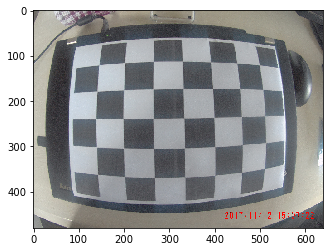

In [3]:
# Import the image and resize it for lower processing.
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = cv2.resize(img, (640, 480))

plt.imshow(resize)
plt.show()

### Pre-procesing

Convert the image to grayscale and perform histogram equilization for better results.

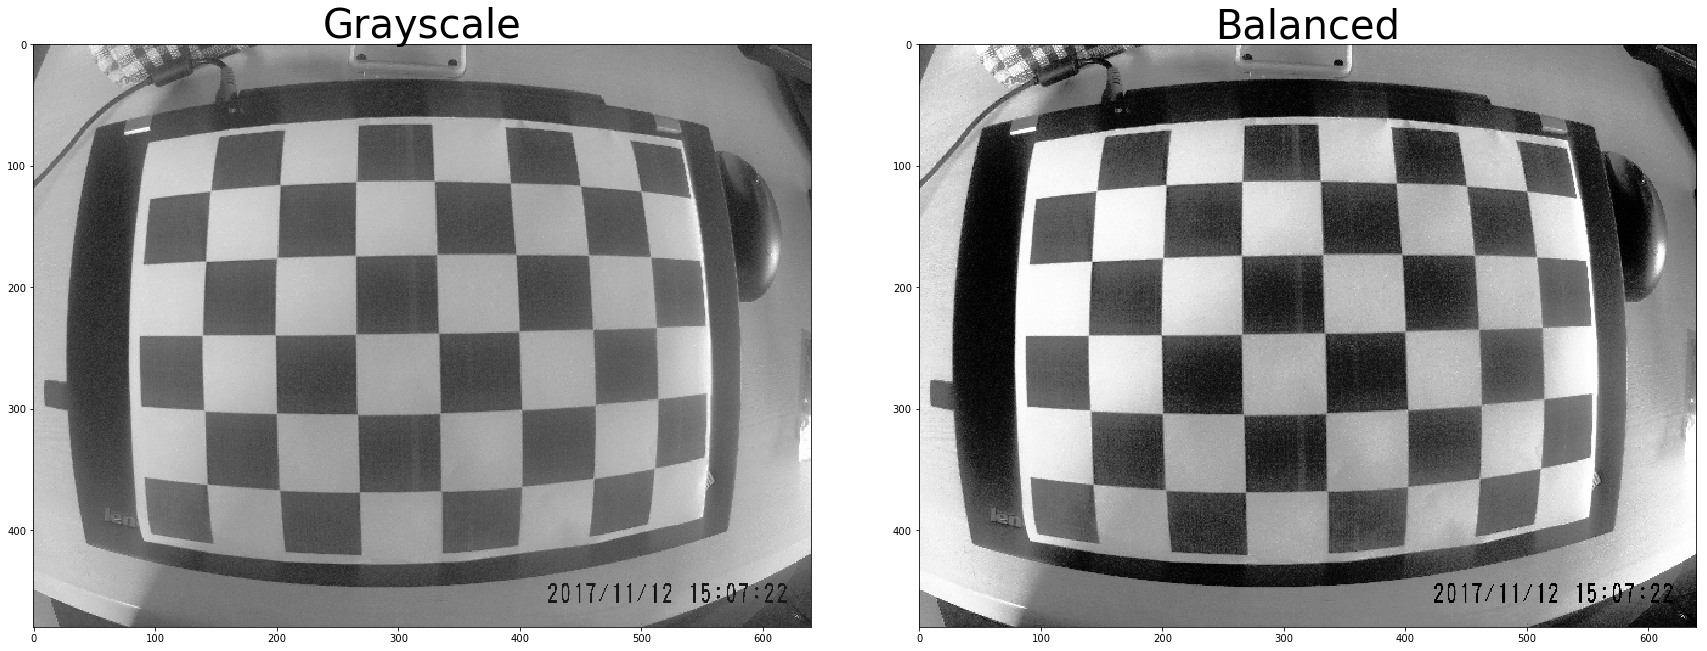

In [4]:
# Convert to grayscale
gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)

# Histogram equilization
balanced = cv2.equalizeHist(gray)

# Display the grayscale and balanced image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(gray, cmap = 'gray')
ax1.set_title('Grayscale', fontsize=40)

ax2.imshow(balanced, cmap='gray')
ax2.set_title('Balanced', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Finding corners:

Findout the corners in the image and display them.

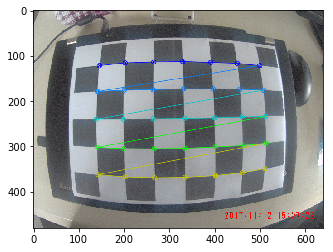

In [5]:
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(balanced, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(resize, (nx, ny), corners, ret)

    plt.imshow(resize)
    plt.show()
else:
    print('Corners not found in the image')

The above code was to find the corners in the image. 
Since it's a chessboard with all blocks as squares of same dimension, the distances between these corners are same.
Hence, the pixel distances of the corners in the image should also be same. But, this is not the case due to the Radial and Tangential distortion caused because of the camera lense.

To solve this problem, we will take number of images from the same camera and use them for calibration.

An image is a matrix of pixels values. If we take distorted image and operate it with undistortion matrix, we will get undistorted image.

To find this undistortion matrix, we will compare 'objpoints' and 'imgpoints'. 'objpoints' are the corners drawn in above image where top left yellow corner is (0, 0) and bottom right blue corner is (7, 5) while 'imgpoints' are the corresponding pixel distances between these corners.

Passing 'objpoints' and 'imgpoints' through ```cv2.calibrateCamera``` function, we will get the undistortion matrix and other parametes using which we can undistort the image.

### Importing multiple images and storing the 'imgpoints' and 'objpoints'

To improve calibration results, we will import multiple chessboard images and store the image-points and object-points in pickle file.

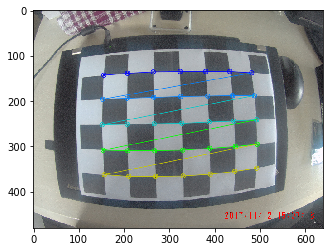

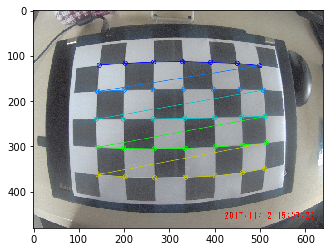

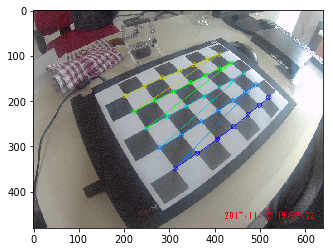

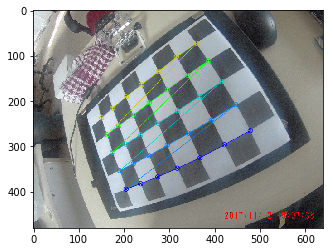

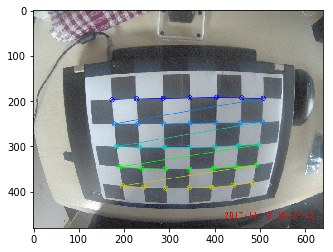

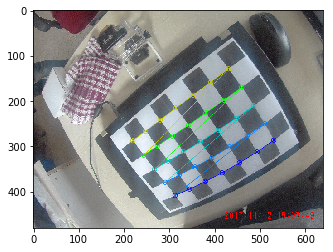

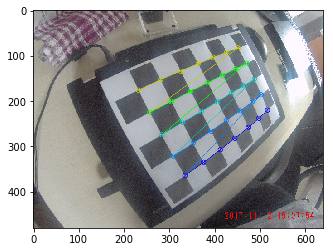

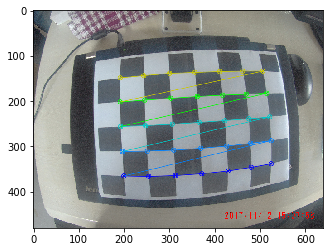

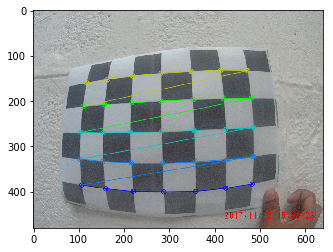

Image and object points are saved in pickle file for later use.


In [19]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:5].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

count = 0
save_count = 0
images = glob.glob('./camera_cal/*.JPG')

for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (640, 480))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    balanced = cv2.equalizeHist(gray)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(balanced, (7, 5), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7, 5), corners2, ret)
        plt.imshow(img, cmap='gray')
        plt.show()
        cv2.waitKey(500)
        
        # Save the result for "output_images" folder
        count += 1
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite('./output_images/'+ str(count) + '_corners'+'.jpg', img)


pickle_out = open("objpoints.pickle", "wb")
pickle_out1 = open("imgpoints.pickle", "wb")

pickle.dump(objpoints, pickle_out)
pickle.dump(imgpoints, pickle_out1)

print('Image and object points are saved in pickle file for later use.')

### Camera caliration and undistortion:

Following is the function which intakes the image, object and image points and returns the undistorted image. 

In [7]:
def cal_undistort(img, objpoints, imgpoints):
    img = img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst

### Displaying both undistorted and distorted image

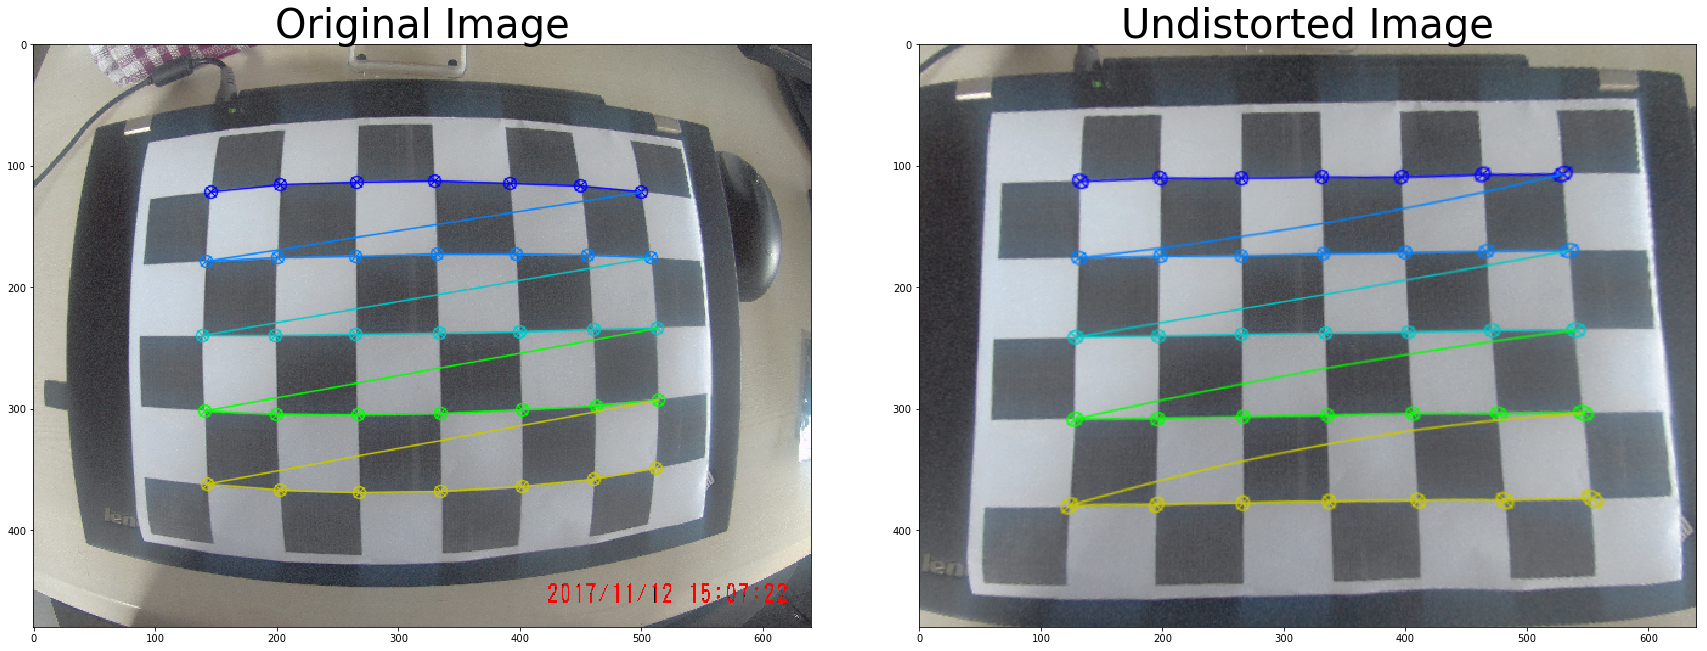

Undistorted image saved to "output_images" folder


In [8]:
undistorted = cal_undistort(resize, objpoints, imgpoints)

# Display the original image and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(resize, cmap = 'gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
cv2.imwrite('./output_images/Undistorted_image.jpg', undistorted)

print('Undistorted image saved to "output_images" folder')

Since we have saved the image points and the data points in pickle file, we can import those files in other code and using cal_undistort function, we can get the undistorted image for this particular camera.

### Save Undistorted Images:

In [20]:
files = './camera_cal/1.JPG'

images = glob.glob('./camera_cal/*.JPG')

for files in images:
    img = cv2.imread(files)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (640, 480))

    img = cal_undistort(img, objpoints, imgpoints)
    cv2.waitKey(500)
        
    # Save the result for "output_images" folder
    save_count += 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('./output_images/'+ str(save_count) + '_undistorted'+'.jpg', img)

print('Undistorted images saved to "output_images" folder')

Undistorted images saved to "output_images" folder
